In [2]:
library(rpart)
library(rpart.plot)
library(RColorBrewer)
library(MLmetrics)
library(caret)

In [3]:
setwd('C:/Users/danie/Documents/GitHub/Quantifying-The-World/Case Study 3')
spamPath = "./From 2ds"

In [4]:
dirNames = list.files(path = paste(spamPath, "messages", 
                      sep = .Platform$file.sep))
fullDirNames = paste(spamPath, "messages", dirNames, 
                     sep = .Platform$file.sep)
fileNames = list.files(fullDirNames[1], full.names = TRUE)
msg = readLines(fileNames[1])

In [5]:
indx = c(1:5, 15, 27, 68, 69, 329, 404, 427, 516, 852, 971)
fn = list.files(fullDirNames[1], full.names = TRUE)[indx]
sampleEmail = sapply(fn, readLines)

In [6]:
splitMessage = function(msg) {
    splitPoint = match("", msg)
    header = msg[1:(splitPoint-1)]
    body = msg[ -(1:splitPoint) ]
    return(list(header = header, body = body)) 
}
sampleSplit = lapply(sampleEmail, splitMessage)

In [7]:
header = sampleSplit[[1]]$header
headerList = lapply(sampleSplit, function(msg) msg$header)
CTloc = sapply(headerList, grep, pattern = "Content-Type")

hasAttach = sapply(headerList, function(header) {
  CTloc = grep("Content-Type", header)
  if (length(CTloc) == 0) return(FALSE)
  grepl("multi", tolower(header[CTloc])) 
})

header = sampleSplit[[6]]$header
boundaryIdx = grep("boundary=", header)


header2 = headerList[[9]]
boundaryIdx2 = grep("boundary=", header2)

In [8]:
getBoundary = function(header) {
  boundaryIdx = grep("boundary=", header)
  boundary = gsub('"', "", header[boundaryIdx])
  gsub(".*boundary= *([^;]*);?.*", "\\1", boundary)
}

In [9]:
dropAttach = function(body, boundary){
  
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  
  if (length(bStringLocs) <= 1) return(body)
  
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  if (length(eStringLoc) == 0) 
    return(body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1)])
  
  n = length(body)
  if (eStringLoc < n) 
     return( body[ c( (bStringLocs[1] + 1) : (bStringLocs[2] - 1), 
                    ( (eStringLoc + 1) : n )) ] )
  
  return( body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1) ])
}

cleanMsg = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", msg))

In [11]:
library(tm)
stopWords = stopwords()
cleanSW = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", stopWords))
SWords = unlist(strsplit(cleanSW, "[[:blank:]]+"))
SWords = SWords[ nchar(SWords) > 1 ]
stopWords = unique(SWords)

In [12]:
words = unlist(strsplit(cleanMsg, "[[:blank:]]+"))

words = words[ nchar(words) > 1 ]

words = words[ !( words %in% stopWords) ]

cleanText =
function(msg)   {
  tolower(gsub("[[:punct:]0-9[:space:][:blank:]]+", " ", msg))
}

findMsgWords = 
function(msg, stopWords) {
 if(is.null(msg))
  return(character())

 words = unique(unlist(strsplit(cleanText(msg), "[[:blank:]\t]+")))
 
 # drop empty and 1 letter words
 words = words[ nchar(words) > 1]
 words = words[ !( words %in% stopWords) ]
 invisible(words)
}

In [13]:
processAllWords = function(dirName, stopWords) {
    fileNames = list.files(dirName, full.names = TRUE)
    notEmail = grep("cmds$", fileNames)
    if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]
    
    messages = lapply(fileNames, readLines, encoding = "latin1")
    
    emailSplit = lapply(messages, splitMessage)
    
    bodyList = lapply(emailSplit, function(msg) msg$body)
    headerList = lapply(emailSplit, function(msg) msg$header)
    rm(emailSplit)
            hasAttach = sapply(headerList, function(header) {
                CTloc = grep("Content-Type", header)
                if (length(CTloc) == 0) return(0)
                multi = grep("multi", tolower(header[CTloc]))
                if (length(multi) == 0) return(0)
                multi
            })
                hasAttach = which(hasAttach > 0)
                boundaries = sapply(headerList[hasAttach], getBoundary)
                bodyList[hasAttach] = mapply(dropAttach, bodyList[hasAttach],
                boundaries, SIMPLIFY = FALSE)
                msgWordsList = lapply(bodyList, findMsgWords, stopWords)
        }

In [14]:
msgWordsList = lapply(fullDirNames, processAllWords, 
                      stopWords = stopWords)

Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/spam/00136.faa39d8e816c70f23b4bb8758d8a74f0'"
Warning message in FUN(X[[i]], ...):
"incomplete final line found on './From 2ds/messages/spam/0143.260a940290dcb61f9327b224a368d4af'"


In [15]:
numMsgs = sapply(msgWordsList, length)
isSpam = rep(c(FALSE, FALSE, FALSE, TRUE, TRUE), numMsgs)
msgWordsList = unlist(msgWordsList, recursive = FALSE)

In [16]:
numEmail = length(isSpam)
numSpam = sum(isSpam)
numHam = numEmail - numSpam

Here is use of sample function

In [17]:
set.seed(418910)
#determine the indices of test spam and ham messages with
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))
# use these indices to select the word vectors from msgWordsList with
testMsgWords = c((msgWordsList[isSpam])[testSpamIdx],
                 (msgWordsList[!isSpam])[testHamIdx] )
trainMsgWords = c((msgWordsList[isSpam])[ - testSpamIdx], 
                  (msgWordsList[!isSpam])[ - testHamIdx])

testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(testSpamIdx), length(testHamIdx)))
trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(testSpamIdx), 
                   numHam - length(testHamIdx)))

Here are probability estimates

In [18]:
bow = unique(unlist(trainMsgWords))
spamWordCounts = rep(0, length(bow))
names(spamWordCounts) = bow

In [19]:
tmp = lapply(trainMsgWords[trainIsSpam], unique)
tt = table( unlist(tmp) )
spamWordCounts[ names(tt) ] = tt

In [20]:
#For each word in bag of words (bow), we compute the number of
#spam messages in our training set that contain that word.
computeFreqs =
function(wordsList, spam, bow = unique(unlist(wordsList)))
{
   # create a matrix for spam, ham, and log odds
  wordTable = matrix(0.5, nrow = 4, ncol = length(bow), 
                     dimnames = list(c("spam", "ham", 
                                        "presentLogOdds", 
                                        "absentLogOdds"),  bow))

   # For each spam message, add 1 to counts for words in message
  counts.spam = table(unlist(lapply(wordsList[spam], unique)))
  wordTable["spam", names(counts.spam)] = counts.spam + .5
  counts.ham = table(unlist(lapply(wordsList[!spam], unique)))  
  wordTable["ham", names(counts.ham)] = counts.ham + .5  
  numSpam = sum(spam)
  numHam = length(spam) - numSpam

   # Probabilities
  wordTable["spam", ] = wordTable["spam", ]/(numSpam + .5)
  wordTable["ham", ] = wordTable["ham", ]/(numHam + .5)
  
   # log odds
  wordTable["presentLogOdds", ] = 
     log(wordTable["spam",]) - log(wordTable["ham", ])
  wordTable["absentLogOdds", ] = 
     log((1 - wordTable["spam", ])) - log((1 -wordTable["ham", ]))

  invisible(wordTable)
}

In [21]:
trainTable = computeFreqs(trainMsgWords, trainIsSpam)

Now, trainTable can be used to construct the log likelihood ratio for a new message. That is, we select values from the matrix trainTable that correspond to the words that appear in a new message and the words that are absent from the message, and we use these to compute the log likelihood ratio for the message. This value is then used to classify the message as spam or ham.

In [22]:
trainTable

,fight,risk,cancer,http,www,adclick,ws,cfm,pk,slim,...,outdata,allocates,initialize,constants,generality,stringlist,toarray,newinstance,nulls,bloch
spam,0.0109477635,0.09352518,0.016578042,0.81420081,0.5045355,0.0147012825,0.02408508,0.016578042,0.0172036284,0.014075696,...,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04,3.127932e-04
ham,0.0106807638,0.01434890,0.005070666,0.78811091,0.5811846,0.0003236595,0.01219117,0.014780451,0.0007552055,0.005286439,...,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04,3.236595e-04
presentLogOdds,0.0246908402,1.87455707,1.184606941,0.03256821,-0.1414302,3.8159979419,0.68088023,0.114773617,3.1258856650,0.979304820,...,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02,-3.414966e-02
absentLogOdds,-0.0002699187,-0.08373918,-0.011633430,-0.13139654,0.1680654,-0.0144867053,-0.01211377,-0.001826225,-0.0165978394,-0.008875237,...,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05,1.086973e-05


Calculate the log likelihood ratio (LLR) for all of the test messages

In [23]:
computeMsgLLR = function(words, freqTable) 
{
       # Discards words not in training data.
  words = words[!is.na(match(words, colnames(freqTable)))]

       # Find which words are present
  present = colnames(freqTable) %in% words

  sum(freqTable["presentLogOdds", present]) +
    sum(freqTable["absentLogOdds", !present])
}

In [24]:
testLLR = sapply(testMsgWords, computeMsgLLR, trainTable)

Compare the summary statistics of the LLR values for the ham and spam in the test data

In [25]:
tapply(testLLR, testIsSpam, summary)

$`FALSE`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1076.8  -137.2  -108.3  -125.6   -88.6   753.5 

$`TRUE`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -85.759   -7.506   36.431   84.980  111.270 1457.719 


We need to decide on a cut-oﬀ τ, where we classify a message as spam or ham according to whether or not the LLR exceeds this threshold. We assess the choice of τ using our test data.

In [26]:
typeIErrorRate = 
function(tau, llrVals, spam)
{
  classify = llrVals > tau
  sum(classify & !spam)/sum(!spam)
}

typeIErrorRates = 
function(llrVals, isSpam) 
{
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]

  idx = which(!isSpam)
  N = length(idx)
  list(error = (N:1)/N, values = llrVals[idx])
}

In [27]:
typeIErrorRate(33, testLLR,testIsSpam)

[1] 0.001294778

In [28]:
typeIIErrorRates = function(llrVals, isSpam) {
    
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]
    
    
  idx = which(isSpam)
  N = length(idx)
  list(error = (1:(N))/N, values = llrVals[idx])
  }  

xI = typeIErrorRates(testLLR, testIsSpam)
xII = typeIIErrorRates(testLLR, testIsSpam)
tau01 = round(min(xI$values[xI$error <= 0.01]))
t2 = max(xII$error[ xII$values < tau01 ])

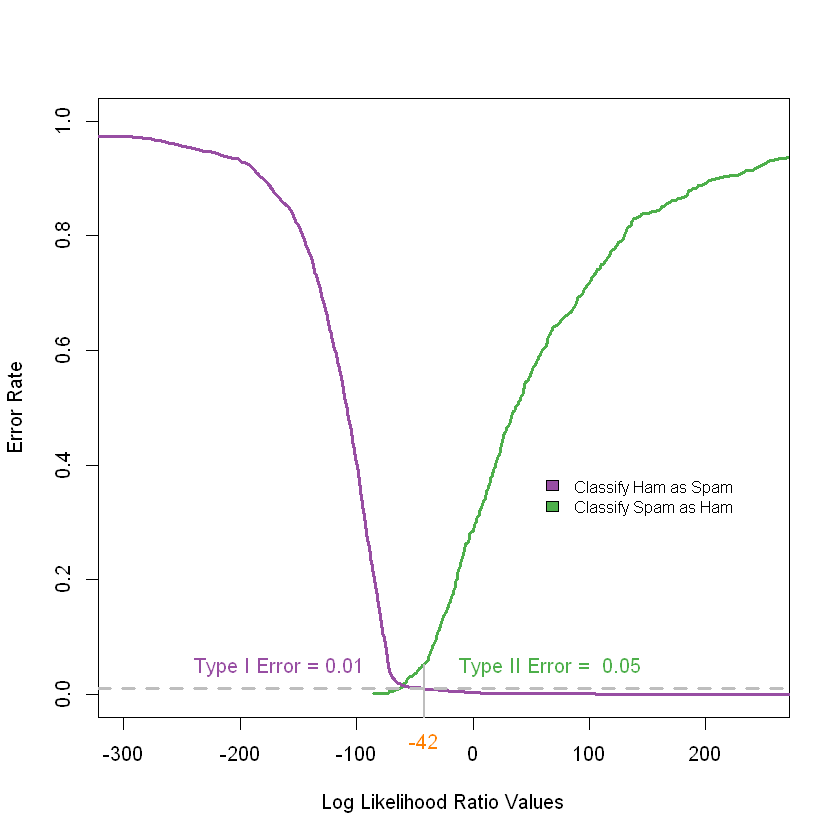

In [29]:
library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(xII$error ~ xII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate")
points(xI$error ~ xI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]),
       legend = c("Classify Ham as Spam", 
                  "Classify Spam as Ham"), cex = 0.8,
       bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tau01, side = 1, line = 0.5, at = tau01, col = cols[3])
segments(x0 = tau01, y0 = -.50, x1 = tau01, y1 = t2, 
         lwd = 2, col = "grey")
text(tau01 + 20, 0.05, pos = 4,
     paste("Type II Error = ", round(t2, digits = 2)), 
     col = cols[1])

__(a)__ Use the sample() function to permute the indices of the training set, and organize these permuted indices into 5 equal-size sets, called folds. 

In [30]:
##Definitely a better way to do this but no time

set.seed(543465)
#Changes to divide by 5 rather than 3 since 5 folds
one_testSpamIdx = sample(numSpam, size = floor(numSpam/5))
one_testHamIdx = sample(numHam, size = floor(numHam/5))
two_testSpamIdx = sample(numSpam, size = floor(numSpam/5))
two_testHamIdx = sample(numHam, size = floor(numHam/5))
three_testSpamIdx = sample(numSpam, size = floor(numSpam/5))
three_testHamIdx = sample(numHam, size = floor(numHam/5))
four_testSpamIdx = sample(numSpam, size = floor(numSpam/5))
four_testHamIdx = sample(numHam, size = floor(numHam/5))
five_testSpamIdx = sample(numSpam, size = floor(numSpam/5))
five_testHamIdx = sample(numHam, size = floor(numHam/5))

# use these indices to select the word vectors from msgWordsList with
testMsgWords = c((msgWordsList[isSpam])[testSpamIdx],
                 (msgWordsList[!isSpam])[testHamIdx] )
trainMsgWords = c((msgWordsList[isSpam])[ - testSpamIdx], 
                  (msgWordsList[!isSpam])[ - testHamIdx])

one_testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(one_testSpamIdx), length(one_testHamIdx)))
one_trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(one_testSpamIdx), 
                   numHam - length(one_testHamIdx)))

two_testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(two_testSpamIdx), length(two_testHamIdx)))
two_trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(two_testSpamIdx), 
                   numHam - length(two_testHamIdx)))

three_testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(three_testSpamIdx), length(three_testHamIdx)))
three_trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(three_testSpamIdx), 
                   numHam - length(three_testHamIdx)))

four_testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(four_testSpamIdx), length(four_testHamIdx)))
four_trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(four_testSpamIdx), 
                   numHam - length(four_testHamIdx)))

five_testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(five_testSpamIdx), length(five_testHamIdx)))
five_trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(five_testSpamIdx), 
                   numHam - length(five_testHamIdx)))

__(b)__  Foreachfold, take the corresponding subset from the training data to use as a‘test’ set. Use the remaining messages in the training data as the training set. Apply the functions developed in Section 3.6 to estimate the probabilities that a word occurs in a message given it is spam or ham, and use these probabilities to compute the log likelihood ratio for the messages in the training set.

In [31]:
#(b) Foreachfold, take the corresponding...
one_trainTable = computeFreqs(trainMsgWords, one_trainIsSpam)
two_trainTable = computeFreqs(trainMsgWords, two_trainIsSpam)
three_trainTable = computeFreqs(trainMsgWords, three_trainIsSpam)
four_trainTable = computeFreqs(trainMsgWords, four_trainIsSpam)
five_trainTable = computeFreqs(trainMsgWords, five_trainIsSpam)

__(c)__ Pool all of the LLR values from the messages in all of the folds, i.e., from all of the training data, and use these values and the typeIErrorRate() function to select a threshold that achieves a 1% Type I error.

In [32]:
#(c) Pool all of the LLR values ...
l <- list(one_trainTable, two_trainTable, three_trainTable, four_trainTable, five_trainTable)
new_trainTable<-do.call(rbind, l)

new_testLLR = sapply(testMsgWords, computeMsgLLR, new_trainTable)


In [48]:
typeIErrorRate(30, new_testLLR,testIsSpam)

[1] 0.009495037

__(d)__ Apply this threshold to our original/real test set and ﬁnd its Type I and Type II errors.

In [46]:
#(d) Apply this threshold...
xI = typeIErrorRates(new_testLLR, testIsSpam)
xII = typeIIErrorRates(new_testLLR, testIsSpam)
tau01 = round(min(xI$values[xI$error <= 0.01]))
t2 = max(xII$error[ xII$values < tau01 ])

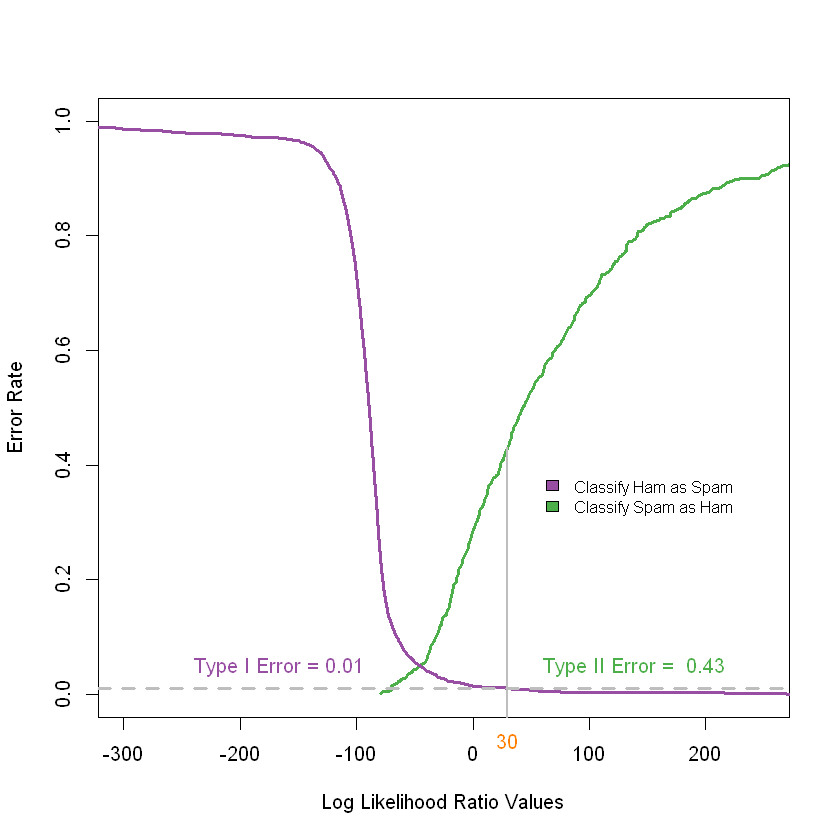

In [47]:
library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(xII$error ~ xII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate")
points(xI$error ~ xI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]),
       legend = c("Classify Ham as Spam", 
                  "Classify Spam as Ham"), cex = 0.8,
       bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tau01, side = 1, line = 0.5, at = tau01, col = cols[3])
segments(x0 = tau01, y0 = -.50, x1 = tau01, y1 = t2, 
         lwd = 2, col = "grey")
text(tau01 + 20, 0.05, pos = 4,
     paste("Type II Error = ", round(t2, digits = 2)), 
     col = cols[1])